# `spline_fxns` module tutorial

This tutorial showcases the usage and results of the three methods implemented in the `brainlit.algoritm.trace_analysis.spline_fxns` module:

1. `speed()`

2. `curvature()`

3. `torsion()`

Here, we will apply the module's methods to a synthetic case where

$f: u \mapsto [u^3, \sin(u), u^2], u \in [-\pi, \pi]$,

using B-Splines with order $k \in \{1, 2, 3, 4, 5\}$. The goal of the experiment is to show how changing the order of the B-Spline affects the accuracy of the methods with respects to the theoretical ground truth. We remark that `scipy.interpolate.BSpline` has a default value of $k = 3$.

First of all, it is important to remark that values of $k$ less or equal to $2$ should be avoided because they provide very poor results. Furthermore, $k=1$ cannot be used to evaluate the curvature because B-Splines with order $1$ do not have a second derivative, and $k=2$ cannot be used to evaluate the torsion because B-Splines with order $2$ do not have a third derivative. The results of this experiment suggest that it is not necessarily true that higher orders will provide more accurate results, since the accuracy varies with the value of the parameter that we are trying to estimate. For example, we will show in this experiment that a B-Spline with order $5$ is better than a B-Spline with order $3$ when the torsion is much greater than $0$, while its performance degrades almost completely for values close to $0$. 

To conclude, this simple experiment wants to show the performance of the `spline_fxns` module on a synthetic, 3D curve. By changing the order of the B-Spline used to interpolate the curve, we see that the accuracy of the methods changes significantly. We do not provide a general rule to pick the best value of $k$, but we suggest that using $k=3,4$ could provide a better performance on average, avoiding singularities that can arise with $k = 5$.

## 0. Define and evaluate the function

Here, we define and plot the function $f$ - the ground truth of the experiment.

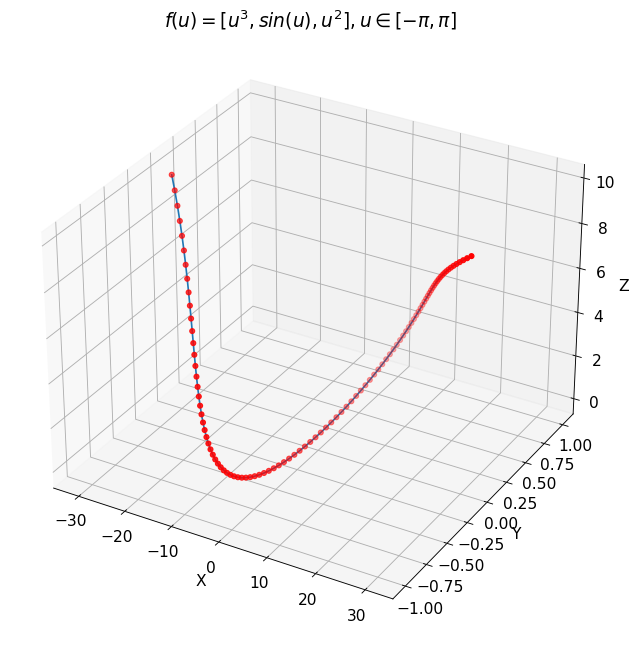

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from brainlit.algorithms.trace_analysis import spline_fxns
from scipy.interpolate import BSpline, splprep

# define the paremeter space
theta = np.linspace(-np.pi, np.pi, 100)
L = len(theta)
# define f(u)
X = theta**3
Y = np.sin(theta)
Z = theta**2
# define df(u)
dX = 3*theta**2
dY = np.cos(theta)
dZ = 2*theta
# define ddf(u)
ddX = 6*theta
ddY = -np.sin(theta)
ddZ = 2 * np.ones(L)
# define dddf(u)
dddX = 6 * np.ones(L)
dddY = -np.cos(theta)
dddZ = np.zeros(L)

# define the ground-truth arrays
C = np.array([X, Y, Z])
dC = np.array([dX, dY, dZ]).T
ddC = np.array([ddX, ddY, ddZ]).T
dddC = np.array([dddX, dddY, dddZ]).T

# plot f(u)
fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot(X, Y, Z)
ax.scatter(X, Y, Z, c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(r"$f(u) = [u^3, sin(u), u^2], u \in [-\pi, \pi]$")
plt.show()

## 1. Speed

The speed measures how fast a point is moving on a parametric curve. 

Let $F: \mathbf{R} \to \mathbf{R}^d$ be a differentiable function, its speed is the $\ell^2$-norm of $\mathbf{J}(F) = \left[\frac{\partial F_i}{\partial x}, \dots , \frac{\partial F_d}{\partial x}\right]$.

Given $u_1, \dots, u_N$ evaluation points of the parameter, we will compare the results of `spline_fxns.speed()` (denoted with $\hat{S_k}$) with the ground truth $S = ||\mathbf{J}(f)||_2 = \sqrt{(3u_i^2)^2 + (\cos(u_i))^2 + (2u_i)^2}$. Here, we will use the uniform norm of the relative error:

$||\mathcal{E}||_\infty = \max |\mathcal{E}|,\quad \mathcal{E} = \frac{S(u) - \hat{S_k}(u)}{S(u)}$,

to evaluate the accuracy as a function of $k$.

$Fig.1$ shows the estimated speed and its error for $k \in \{1, 2, 3, 4, 5\}$. Specifically, we see that the default value of $k=3$ implies a $10\%$ error on the speed, while $k=5$ performs better, with an error $\sim 1\%$.

Text(0.5, 0.98, 'Fig.1 Estimating the speed of a curve via B-Spline interpolation')

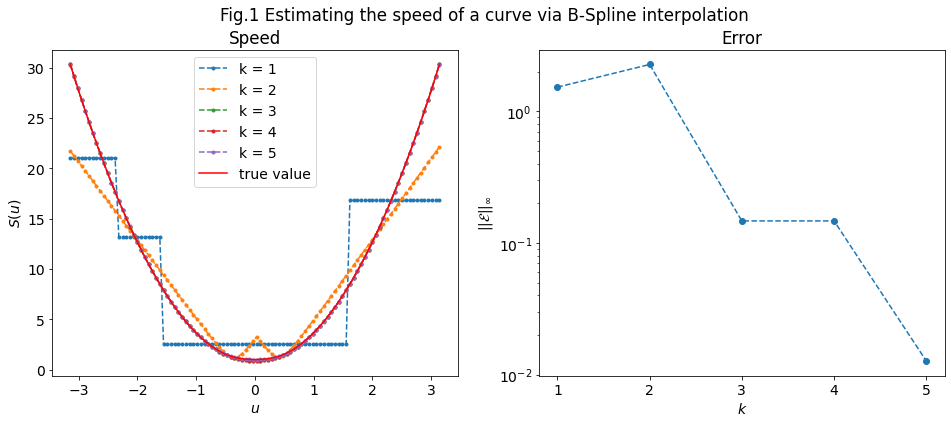

In [8]:
# prepare output figure and axes
fig = plt.figure(figsize=(16, 6))
axes = fig.subplots(1, 2)

# evaluate the theoretical expected value S(u)
expected_speed = np.linalg.norm(dC, axis=1)

# initialize vector of B-Spline orders to test
ks = [1, 2, 3, 4, 5]
# initialize vector that will contain the relative errors
uniform_err = []
for k in ks:
    tck, u = splprep(C, u=theta, k=k)
    t = tck[0]
    c = tck[1]
    k = tck[2]
    speed = spline_fxns.speed(theta, t, c, k, aux_outputs=False)
    # plot the estimated curvature
    axes[0].plot(theta, speed, "o--",  label="k = %d" % k, markersize=3)
    # evaluate the uniform error
    uniform_err.append(np.amax(np.abs((expected_speed - speed)/expected_speed)))

# plot speed
ax = axes[0]
ax.plot(theta, expected_speed, c="r", label="true value")
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$S(u)$")
ax.set_title("Speed")
ax.legend()

# plot error
ax = axes[1]
ax.plot(ks, uniform_err, "o--")
ax.set_yscale("log")
ax.set_xlabel(r"$k$")
ax.set_xticks(ks)
ax.set_ylabel(r"$||\mathcal{E}||_\infty$")
ax.set_title("Error")

fig.suptitle("Fig.1 Estimating the speed of a curve via B-Spline interpolation")

## 2. Curvature

The curvature measures the failure of a curve to be a straight line.

Given $u_1, \dots, u_N$ evaluation points of the parameter, the expected curvature vector $C$ for the ground truth function $f$ is

$C(u) = \lVert f'(u) \times f''(u) \rVert \; / \; \lVert f'(u) \rVert^3$.

Here, we will compare the results of `spline_fxns.curvature()` (denoted with $\hat{C_k}$) with the ground truth $C$. Again, we will use the uniform norm of the relative error:

$||\mathcal{E}||_\infty = \max |\mathcal{E}|,\quad \mathcal{E} = \frac{C(u) - \hat{C_k}(u)}{C(u)}$,

to evaluate the accuracy as a function of $k$.

$Fig.2$ shows the estimated curvature and its error for $k \in \{1, 2, 3, 4, 5\}$. For $k=1$, the curvature is identically $0$ for any $u$ because the second derivative of a B-Spline of order $1$ does not exist, and we set it to $0$. Specifically, we see that the default value of $k=3$ implies a $\sim 30\%$ error on the curvature, which is much higher than the previous error found for the speed. We also see that for $k=5$ the uniform error is $\sim 10\%$, which is almost $10$ times bigger than the error on the speed for $k=5$.

Text(0.5, 0.98, 'Fig.2 Estimating the curvature of a line via B-Spline interpolation')

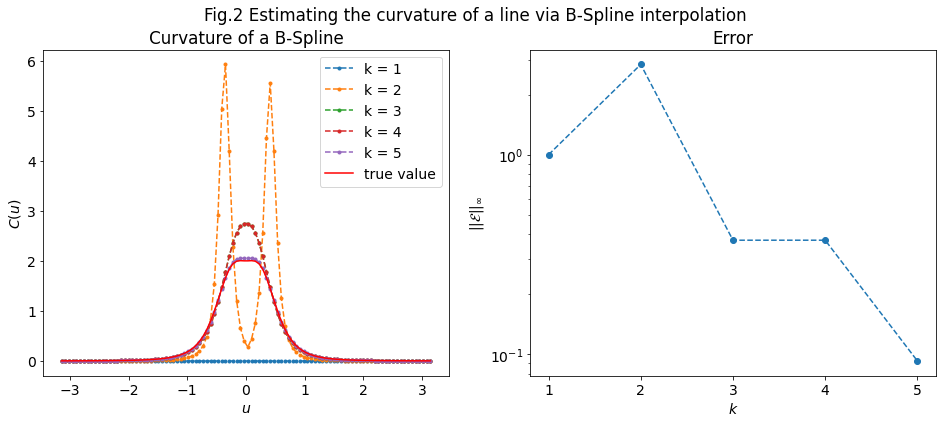

In [11]:
# prepare output figure and axes
fig = plt.figure(figsize=(16, 6))
axes = fig.subplots(1, 2)

# evaluate the theoretical expected value C(u)
cross = np.cross(dC, ddC)
num = np.linalg.norm(cross, axis=1)
denom = np.linalg.norm(dC, axis=1) ** 3
expected_curvature = np.nan_to_num(num / denom)

# initialize vector of B-Spline orders to test
ks = [1, 2, 3, 4, 5]
# initialize vector that will contain the relative errors
uniform_err = []
for k in ks:
    tck, u = splprep(C, u=theta, k=k)
    t = tck[0]
    c = tck[1]
    k = tck[2]
    curvature, deriv, dderiv = spline_fxns.curvature(theta, t, c, k, aux_outputs=True)
    # plot the estimated curvature
    axes[0].plot(theta, curvature, "o--", label="k = %d" % k, markersize=3)
    # evaluate the uniform error
    uniform_err.append(np.amax(np.abs((expected_curvature - curvature)/expected_curvature)))

# plot curvature
ax = axes[0]
ax.plot(theta, expected_curvature, c="r", label="true value")
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$C(u)$")
ax.set_title("Curvature of a B-Spline")
ax.legend()

# plot error
ax = axes[1]
ax.plot(ks, uniform_err, "o--")
ax.set_yscale("log")
ax.set_xlabel(r"$k$")
ax.set_xticks(ks)
ax.set_ylabel(r"$||\mathcal{E}||_\infty$")
ax.set_title("Error")

fig.suptitle("Fig.2 Estimating the curvature of a line via B-Spline interpolation")

## 3. Torsion

The torsion measures the failure of a curve to be planar. 

Given $u_1, \dots, u_N$ evaluation points of the parameter, the expected torsion vector $\tau$ for the ground truth function $f$ is

$\tau(u) = \lvert f'(u), f''(u), f'''(u) \rvert \; / \; \lVert f'(u) \times f''(u) \rVert^2$

Here, we will compare the results of `spline_fxns.torsion()` (denoted with $\hat{\tau_k}$) with the ground truth $\tau$. Again, ee will use the uniform norm of the relative error:

$||\mathcal{E}||_\infty = \max |\mathcal{E}|,\quad \mathcal{E} = \frac{\tau(u) - \hat{\tau_k}(u)}{\tau(u)}$,

to evaluate the accuracy as a function of $k$.

$Fig.3$ shows the estimated torsion and its error for $k \in \{1, 2, 3, 4, 5\}$. For $k=1, 2$ the torsion is identically $0$ for any $u$ because the second, third derivatives of a B-Spline of order $1, 2$ respectively, cannot be evaluated, so we set them to $0$. Interestingly, we see that $k=3$ reduces the error compared to $k=5$. This happens because the B-Spline with order $5$ is worse at estimating the long tails close to $0$, while it performs better with larger values of the torsion.

Text(0.5, 0.98, 'Fig.3 Estimating the torsion of a line via B-Spline interpolation')

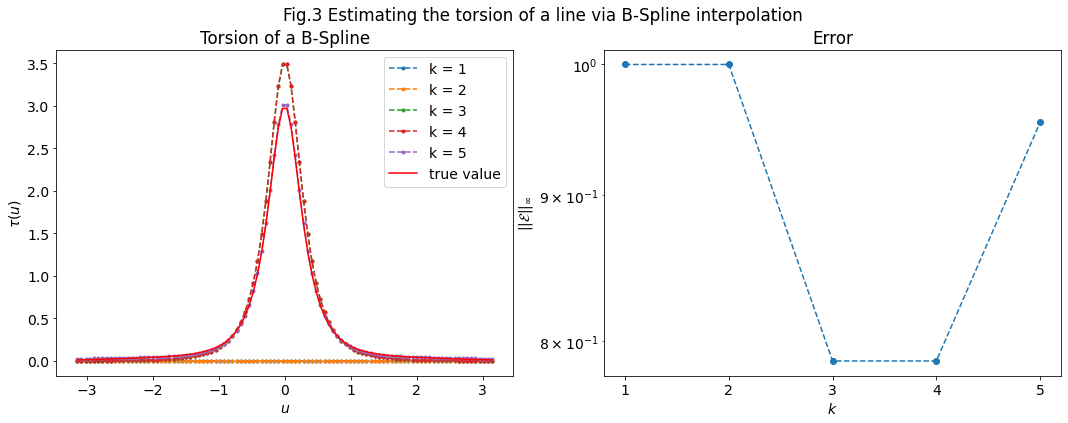

In [9]:
# prepare output figure and axes
fig = plt.figure(figsize=(18, 6))
axes = fig.subplots(1, 2)

# evaluate the theoretical expected value \tau(u)
expected_cross = np.cross(dC, ddC)
expected_num = np.diag((expected_cross @ dddC.T))
expected_denom = np.linalg.norm(expected_cross, axis=1) ** 2
expected_torsion = np.nan_to_num(expected_num / expected_denom)

# initialize vector of B-Spline orders to test
ks = [1, 2, 3, 4, 5]
# initialize vector that will contain the relative errors
uniform_err = []
for k in [1, 2, 3, 4, 5]:
    tck, u = splprep(C, u=theta, k=k)
    t = tck[0]
    c = tck[1]
    k = tck[2]
    torsion = spline_fxns.torsion(theta, t, c, k, aux_outputs=False)
    # plot the estimated curvature
    axes[0].plot(theta, torsion, "o--", label="k = %d" % k, markersize=3)
    # evaluate the uniform error
    uniform_err.append(np.amax(np.abs((expected_torsion - torsion)/expected_torsion)))

# plot torsion
ax = axes[0]
ax.plot(theta, expected_torsion, c="r", label="true value")
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$\tau(u)$")
ax.set_title("Torsion of a B-Spline")
ax.legend()

# plot error
ax = axes[1]
ax.plot(ks, uniform_err, "o--")
ax.set_yscale("log")
ax.set_xlabel(r"$k$")
ax.set_xticks(ks)
ax.set_ylabel(r"$||\mathcal{E}||_\infty$")
ax.set_title("Error")

fig.suptitle("Fig.3 Estimating the torsion of a line via B-Spline interpolation")

In [10]:
curvature, deriv, dderiv = spline_fxns.curvature(theta, t, c, k, aux_outputs=True)
print(deriv, dC)

[[ 2.96088132e+01 -8.71069066e-01 -6.28318531e+00]
 [ 2.84245815e+01 -9.01479929e-01 -6.15625227e+00]
 [ 2.72645178e+01 -9.22808496e-01 -6.02931923e+00]
 [ 2.61286221e+01 -9.35578172e-01 -5.90238620e+00]
 [ 2.50168944e+01 -9.40301452e-01 -5.77545316e+00]
 [ 2.39293347e+01 -9.37479932e-01 -5.64852012e+00]
 [ 2.28659430e+01 -9.27604299e-01 -5.52158709e+00]
 [ 2.18267193e+01 -9.11154340e-01 -5.39465405e+00]
 [ 2.08116635e+01 -8.88598935e-01 -5.26772102e+00]
 [ 1.98207758e+01 -8.60396060e-01 -5.14078798e+00]
 [ 1.88540560e+01 -8.26992789e-01 -5.01385494e+00]
 [ 1.79115043e+01 -7.88825289e-01 -4.88692191e+00]
 [ 1.69931205e+01 -7.46318825e-01 -4.75998887e+00]
 [ 1.60989048e+01 -6.99887756e-01 -4.63305583e+00]
 [ 1.52288570e+01 -6.49935539e-01 -4.50612280e+00]
 [ 1.43829772e+01 -5.96854724e-01 -4.37918976e+00]
 [ 1.35612654e+01 -5.41026959e-01 -4.25225672e+00]
 [ 1.27637216e+01 -4.82822986e-01 -4.12532369e+00]
 [ 1.19903458e+01 -4.22602646e-01 -3.99839065e+00]
 [ 1.12411380e+01 -3.60714871e-